#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Задача построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели (LinearRegression, RandomForestRegressor, LGBMRegressor) с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

In [1]:
%pip install scikit-learn -q -U 
%pip install lightgbm -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, TimeSeriesSplit

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler


from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_error

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [3]:
warnings.filterwarnings('ignore')

In [4]:
RANDOM_STATE = 42

## Подготовка

In [5]:
df = pd.read_csv(r'../datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
df = df.resample('1h').sum()

In [7]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Были загружены данные и проведено первичное ознакомление

## Анализ

In [8]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


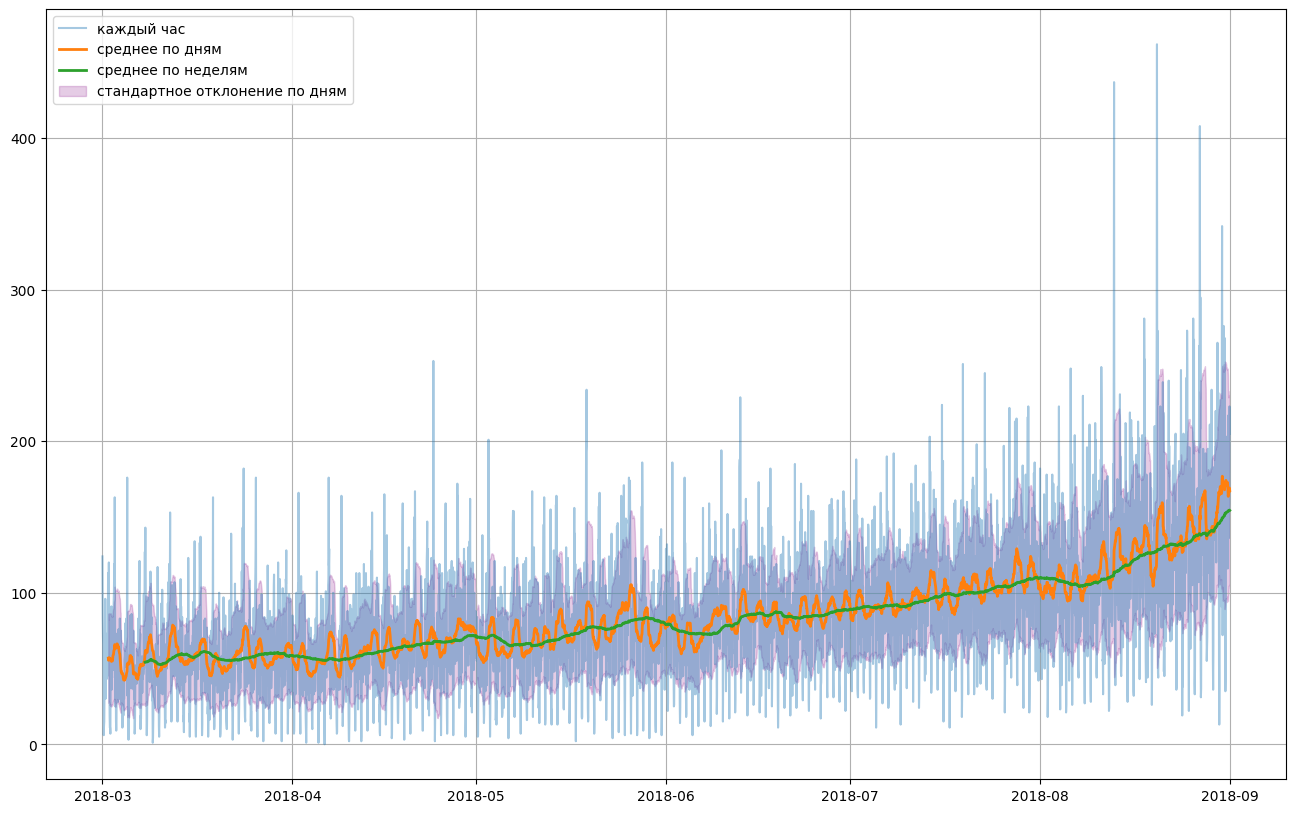

In [9]:
df_plot = df.copy()
df_plot['mean_1d'] = df['num_orders'].rolling(window=24).mean()
df_plot["mean_1w"] = df['num_orders'].rolling(window=24*7).mean()
df_plot["std_1d"] = df['num_orders'].rolling(window=24).std()

plt.figure(figsize=(16, 10))
plt.plot(df_plot.index, df_plot['num_orders'], label='каждый час', alpha=0.4)
plt.plot(df_plot.index, df_plot['mean_1d'], label='среднее по дням', linewidth=2)
plt.plot(df_plot.index, df_plot['mean_1w'],label='среднее по неделям' , linewidth=2)
plt.fill_between(df_plot.index, 
                 df_plot['mean_1d'] - df_plot['std_1d'],
                 df_plot['mean_1d'] + df_plot['std_1d'],
                 label='стандартное отклонение по дням',
                 color='purple',
                 alpha=0.2)   
plt.legend()
plt.grid(True)
plt.show()

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Советую очень осторожно трактовать гистограмму или диаграмму размаха для наших данных. Дело в том, что характеристики даных меняются со временем (и среднее и дисперсия). Поэтому гистограмма покажет тебе только "среднее по больнице" без какой-либо динамики.
</div>

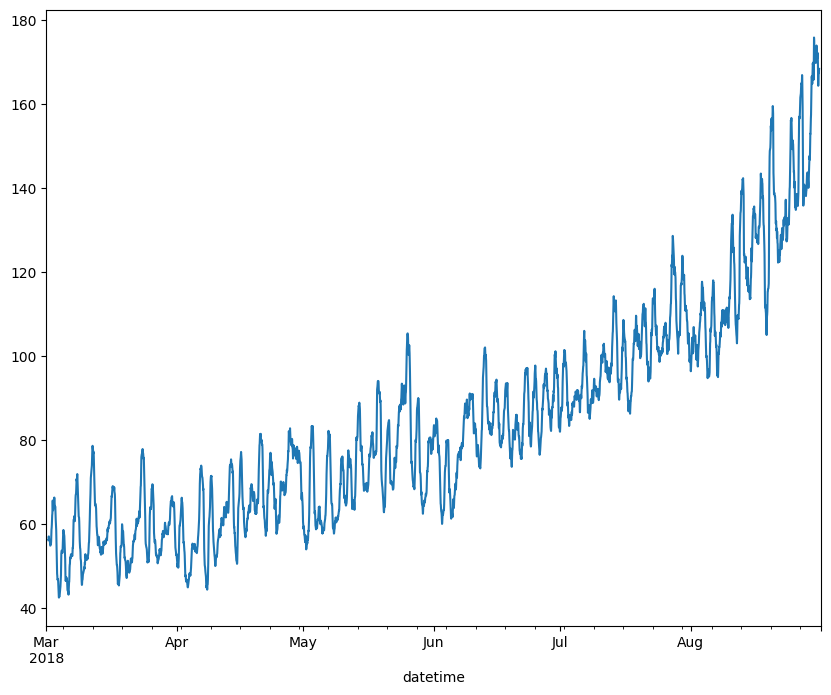

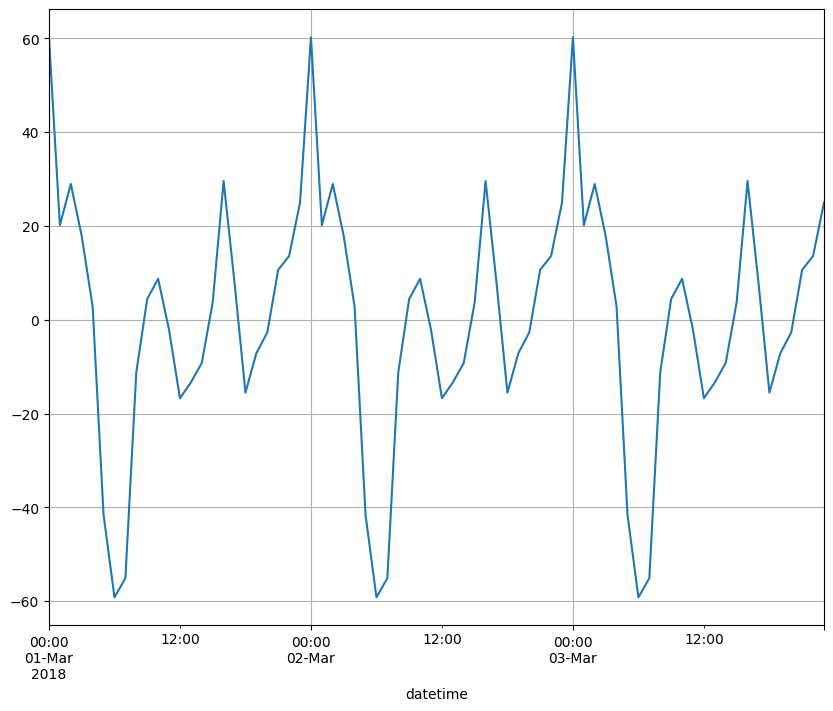

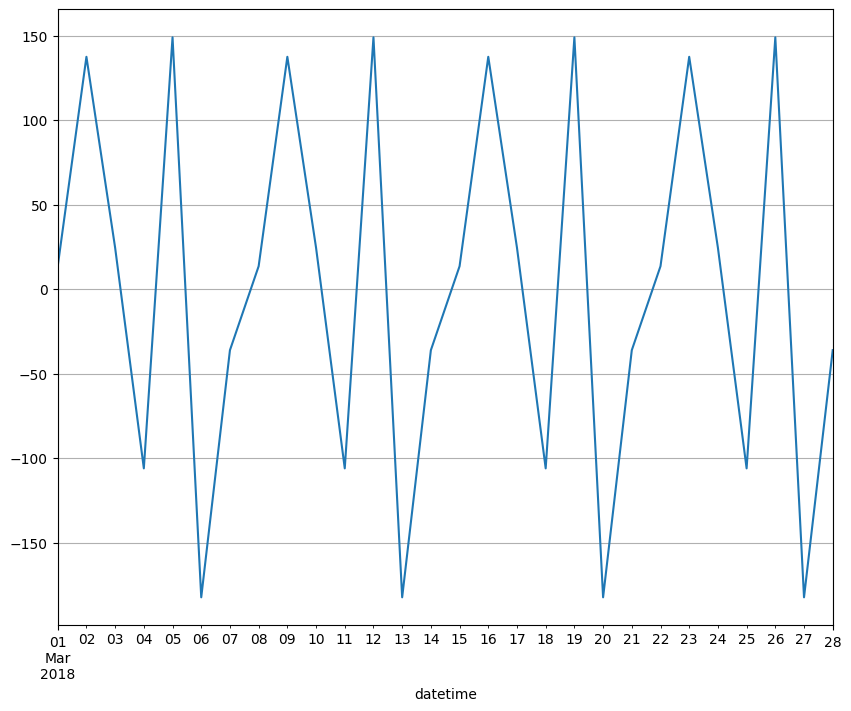

In [10]:
decomposed = seasonal_decompose(df)
decomposed_d = seasonal_decompose(df.resample('1D').sum())

plt.figure(figsize=(10, 8))
decomposed.trend.plot(ax=plt.gca());
plt.show()

plt.figure(figsize=(10, 8))
decomposed.seasonal['2018-03-01':'2018-03-03'].plot(ax=plt.gca());
plt.grid()

plt.figure(figsize=(10, 8))
decomposed_d.seasonal['2018-03-01':'2018-03-28'].plot(ax=plt.gca());
plt.grid()

plt.show()

Видим достаточно высокое стандартное отклонение у целевого признака.<br>
Видим общий тренда на увеличение заказов по дням.<br>
Наблюдаются сезонность у целевого признака в разрезе дня пик в нулях, дальше идет снижение, потом постепенный рост.
Также наблюдается сезонность понедельная.

## Обучение

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    """
    Добавляет в DF новые признаки
    """
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data.num_orders.shift(lag)

    data['rolling_mean'] = data.num_orders.shift().rolling(rolling_mean_size).mean()

In [12]:
#Добавляем новые признаки в датасет
make_features(df, 24, 24)

In [13]:
df.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

print(f'Размер тренировочной выборки {train.shape}')
print(f'Размер тестовой выборки {test.shape}')

Размер тренировочной выборки (3950, 28)
Размер тестовой выборки (442, 28)


In [15]:
X_train, y_train = train.drop('num_orders', axis=1), train.num_orders
X_test, y_test = test.drop('num_orders', axis=1), test.num_orders

In [16]:
num_columns = X_train.select_dtypes(include='number').columns.to_list()

data_preprocessor_linear = ColumnTransformer(
    [
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [17]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor_linear),
        ('models', LinearRegression())
    ]
)    

In [18]:
param_grid = [
    {
        'models':[LinearRegression()],
        'preprocessor__num': [StandardScaler()]
    },
    {
        'models': [LGBMRegressor()],
        'models__num_leaves': range(5, 10),
        'models__max_depth': range(3, 10),
        'preprocessor__num': ['passthrough']
    },
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(97, 103),
        'models__min_samples_split': range(3, 8),
        'models__min_samples_leaf': range(1, 6),
        'preprocessor__num': ['passthrough']
    }
]    

In [19]:
#Добавляем объект TimeSeriesSplit, чтобы выборки не перемешивались при кроссвалидации
tscv = TimeSeriesSplit(n_splits=3)

In [20]:
%%time
gscv = GridSearchCV(
        pipe_final,
        param_grid,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        error_score='raise',
        cv=tscv,
        verbose=3
    ).fit(X_train, y_train)

Fitting 3 folds for each of 186 candidates, totalling 558 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4836
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 27
[LightGBM] [Info] Start training from score 78.421013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
CPU times: total: 3 s
Wall time: 4min 36s


In [21]:
print(f'RMSE на тренировочной выборке лучше модели: {(-1 * gscv.best_score_):.2f}')
print(f'Параметры лучшего pipeline: {gscv.best_params_}')

RMSE на тренировочной выборке лучше модели: 26.09
Параметры лучшего pipeline: {'models': LGBMRegressor(), 'models__max_depth': 4, 'models__num_leaves': 7, 'preprocessor__num': 'passthrough'}


На тренировочных данных лучше всего обучилась модель LGBMRegressor, RMSE на тренировочной выборке у неё 26.09.

## Тестирование

In [22]:
#Сделаем предсказания на тренировочных данных
y_pred = gscv.best_estimator_.predict(X_test)

In [23]:
print(f"RMSE на тестовой выборке равен: {root_mean_squared_error(y_test, y_pred):.2f}")

RMSE на тестовой выборке равен: 43.39


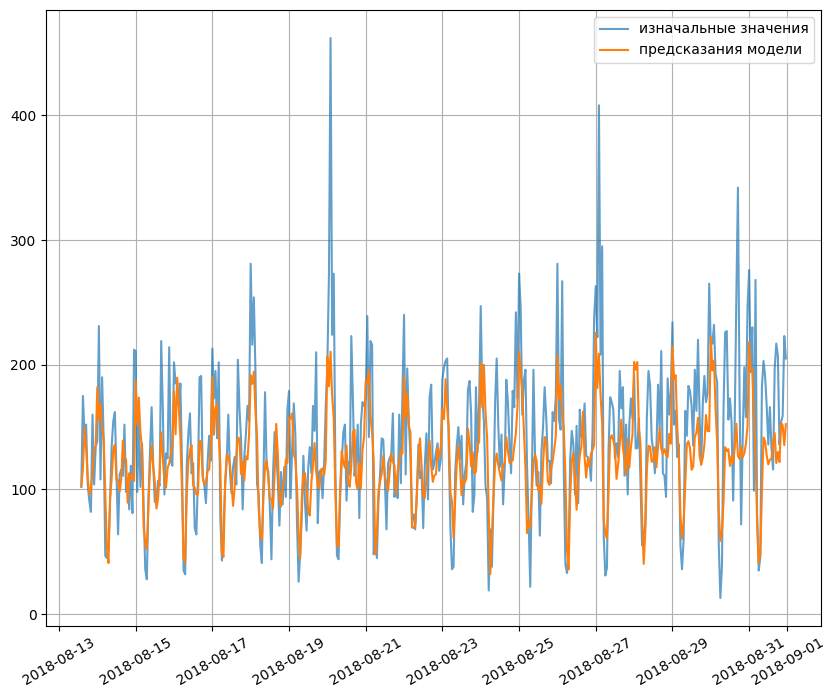

In [24]:
plt.figure(figsize=(10, 8))
plt.plot(y_test.index, y_test, label='изначальные значения', alpha=0.7)
plt.plot(y_test.index, y_pred, label='предсказания модели')
plt.xticks(rotation=30)
plt.legend()
plt.grid()

Видим, что значения предсказания относительно близки к реальным значениям. Единственное, модель хуже всего уловила так называемые выбросы в данных

In [25]:
y_test_copy = pd.DataFrame(y_test.copy())
y_test_copy['lag24'] = y_test_copy['num_orders'].shift(24)
y_test_copy.dropna(inplace=True)
print(f"RMSE со смещением на 1 день: {root_mean_squared_error(y_test_copy['num_orders'], y_test_copy['lag24'])}")

RMSE со смещением на 1 день: 56.241703269041125


Видим, что полученная модель справляется лучше, если бы мы брали данные со смещением в 1 день.<br>
Также наилучшая модель справилась с задачей и мы получили метрику RMSE ниже 48, она равна 43.39.

**Вывод**<br>
- Были загружены данные и приведены к нужному формату. Проведено ресемплирование данных по часам. Добавлены новые признаки.
- Проанализированы данные: найден общий тренд увеличения кол-ва заказов, также сезонность по дням и неделям. Также у целевого показателя высокое стандартное отклонение, что говорит о высоком разбросе данных, относительно среднего.
- Обучены три модели: LinearRegression, LGBMRegressor, RandomForestRegressor. На этапе обучения лучше всего справилась модель LGBMRegressor, RMSE на тренировочной выборке у неё меньше всего и равно 24.61.
- Была применена лучшая модель для тестовых данных. RMSE получилось 41.66. Также проанализировали предсказания модели, относительно реальных значений. Увидели, что модель не лучшим образом определяет выбросы, но в целом предсказания в рамках допустимого отклонения. Также проверили вариант, если бы мы брали значения со смещением в один день. Показатели модели лучше.